In [188]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import deque
import seaborn as sns
from scipy.stats import entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from timeit import default_timer as timer
import sys, os, shutil, gc

In [ ]:
# ''' Version of the packages in this work.'''
# # print("Pandas version: ",pd.__version__)
# print("Pandas version: 0.25.1")
# # print("Numpy version: ",np.__version__)
# print("Numpy version: 1.16.4")
# # print("Sys python version: ",sys.version)
# print("Sys python version: 3.7.1 | package by conda-forge [MSC v.1900 64 bit (AMD64)]")
# print("IPython: 7.8.0")
# print("IPython genutils: 0.2.0")

###  Header

In [ ]:
#toy example dataset
# input_test2.dat and input_test2.dat

#synthetic datasets
# synthetic-1_fimi.dat, synthetic-2_fimi.dat and synthetic-3_fimi.dat

experiment = 'Toy' # Syn: run the synthetic data analysis; Real: run the real data analysis; 
                   # Toy: run the toy example.
toy_number = "2" # sufix of a given toy dataset [1,1-1,2]

find_overlap = False # True: find overlapped co-clusters; False: Find no overlapped co-clusters
VERBOSE = True # True: print results as a verbose mode; False: print the main results
num_of_sim = 1 # number of simulations to perform
k = -1 #max number of co-cluster that could be found. -1: default [driven by cost function]
e_obj = 0.4 # maximum error tolerance for object. -1: default [accept the maximum error]
e_att = .8 # maximum error tolerance for attribute. -1: default [accept the maximum error]

if VERBOSE: print('--->Verbose mode ON.<---')

print("Executing TRACOCLUS method")
if experiment == 'Syn':
    path = "./data/synthetic/fimi/"
    syn_datasets = [path+"synthetic-1_fimi.dat",path+"synthetic-2_fimi.dat",path+"synthetic-3_fimi.dat"]
    path_method = "OutputAnalysis\ococlus"
    check_path(path_method)

    for ds in range(len(syn_datasets)):
        ds_name = "Syn-"+str(ds+1)
        print("\nDataset: "+ds_name)
        res = os.mkdir(path_method+"\\"+ds_name)

        for run in range(num_of_sim):
            print("Run-"+str(run+1))

            df_fimi = pd.read_csv(syn_datasets[ds], header=None, names=["transation"])
            D,co_clusters = OCoClus(df_fimi,k,e_obj,e_att) # Calling OCoClus main method

            print("")
            Rec_error(D,co_clusters)
#             print(co_clusters)
            
            omega_format = build_clustering_output_omega(co_clusters)
            OCoClus_clustering_xm = xmeasures_format(omega_format)# save to XMEASURES format C++ version
            df_gt = pd.DataFrame(OCoClus_clustering_xm)
            path = path_method+"/"+ds_name
            df_gt.to_csv(path.replace("\\","/")+"/run_"+str(run+1)+"_res_ococlus_"+ds_name+"_co.cnl", 
                         header= False,index=False, encoding='utf8')
            del omega_format, df_gt, OCoClus_clustering_xm
            gc.collect()
elif experiment == 'Real':
    k = 10
    print('Real data clustering.')
    path = "./data/real_application/"
    real_datasets = [path+"cal500_fimi.dat",path+"covid19_fimi.dat"]
    path_method = "OutputAnalysis\ococlus"
    check_path(path_method)
    
    for ds in range(len(real_datasets)):
        ds_name = real_datasets[ds].replace("/","_").split("_")[4].capitalize()
        print("\nDataset: "+ds_name)
        res = os.mkdir(path_method+"\\"+ds_name)
        
        df_fimi = pd.read_csv(real_datasets[ds], header=None, names=["transation"])
        D,co_clusters = OCoClus(df_fimi,k,e_obj,e_att) # Calling OCoClus main method
        writeFileOutput(co_clusters,ds_name,method='OCoClus',fileName='OCoClusResult_'+ds_name)
        
    print('DONE!')
elif experiment == 'Toy':
    print('Toy example')
    VERBOSE = False
#     input_data_pd = pd.read_csv("./data/toy_example/toy"+toy_number+"_traj.dat", header=None, names=["transation"])
#     input_data_pd = pd.read_csv("./data/toy_example/toy"+toy_number+"_traj.dat", header=None, names=["transation"])
    input_data_pd = pd.read_csv("./data/real_application/foursquare_NY/fs_ny_week_sequences.dat", header=None, names=["transation"])
#     print(input_data_pd)
    D,co_clusters = TRACOCLUS(input_data_pd,k,e_obj,e_att)
    print(co_clusters)
    #Compute the measures
#     print("")
#     Rec_error(D,co_clusters)
else:
    print('ERROR! Choose a valid option for the experiment analysis.')

## Evaluation (Omega index, overlapped F1, ONMI)

In [ ]:
%%bash
#!/bin/bash
### omega index and f-score
### ./xmeasures -o -fp -ku -O gt.txt cls2.txt
# pwd
# ls

if [ -d "xmeasures/OutputAnalysis/ococlus" ] 
then
#     echo "Directory exists."
    rm -R xmeasures/OutputAnalysis/ococlus
else
    echo "Error: Directory does not exists."
fi

cp -R OutputAnalysis xmeasures
cd xmeasures/

#Method: [Ococlus]
#ground-truth: [gt_xm_s1_co.cnl,gt_xm_s2_co.cnl,gt_xm_s3_co.cnl]
for i in 1 2 3 # index of synthetic datasets
# for i in 1
do
#     for file in OutputAnalysis/ococlus/Syn-${i}/*
    for file in OutputAnalysis/ococlus/Syn-${i}/*
    do
    #     echo " $(grep -c '' ${file})"
        res=$(grep -c '' ${file})
    #     echo "${file} lines equal to: ${res}"

        if [ ${res} != 0 ]
        then 
            echo " "
            echo "File ${file} is not empty. It has ${res} lines."
    #         echo "Empty file"
            ./xmeasures -o -fp -ku -O ./gts/gt_xm_s${i}_trad.cnl ${file} &
            echo " "
        else
              echo "File ${file}"
              echo "Empty file. SKIPPED!"
        fi
#     # wait until all child processes are done
#     wait
    done
    echo " "
    # wait until all child processes are done
    wait
done

### ONMI

In [ ]:
%%bash
#!/bin/bash
#### ONMI
#### ./onmi file1 file2

cd xmeasures

#Method: [Ococlus]
#ground-truth: [gt_xm_s1_trad.cnl,gt_xm_s2_trad.cnl,gt_xm_s3_trad.cnl]
for i in 1 2 3 # index of synthetic datasets
# for i in 1
do
    for file in OutputAnalysis/ococlus/Syn-${i}/*
    do
    #     echo " $(grep -c '' ${file})"
        res=$(grep -c '' ${file})
    #     echo "${file} lines equal to: ${res}"

        if [ ${res} != 0 ]
        then 
            echo " "
            echo "File ${file} is not empty. It has ${res} lines."
    #         echo "Empty file"
            ./onmi ./gts/gt_xm_s${i}_trad.cnl ${file} &
            echo " "
        else
              echo "File ${file}"
              echo "Empty file. SKIPPED!"
        fi
#     # wait until all child processes are done
#     wait
    done
    echo " "
    # wait until all child processes are done
    wait
done

# TraCoClus algorithm

This is the main algorithm of TraCoClus.

In [ ]:
er = '0-3-1-4-0-1'
er2 = er.split('-')
print(er2)
# print(er2.nunique())
def change_vect_cont(queue):
    queue[0] = 'Q'

In [ ]:
my_vect = [1,2,8,4]
change_vect_cont(my_vect)
print(my_vect)

In [ ]:
import seaborn as sns
# %matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
max_tested_atts = np.log2(10)
vec_log_num = [1,10,20,30,40,50,60,70,80,90,100]#,250,500]#,750,1000]#,1500,2000,3000,5000,7500,10000]
base = [2,10]
df_log_base_diff = pd.DataFrame(columns = ['Input x','Log Result','Log Base'])
popupalte_df_dict = {'Input x':0,'Log Result':0,'Log Base':''}

for base_i in base:
    popupalte_df_dict['Log Base'] = 'Log_'+str(base_i)
    for num in vec_log_num:
        popupalte_df_dict['Input x'] = num
#         if base_i == 2:
#         popupalte_df_dict['Log Result'] = np.log2(num)    
        popupalte_df_dict['Log Result'] = np.log(num)/np.log(base_i)
#         else:
#             popupalte_df_dict['Log Result'] = np.log10(num)
        df_log_base_diff = df_log_base_diff.append(popupalte_df_dict, ignore_index=True)
df_log_base_diff.head()
sns.lineplot(data=df_log_base_diff, x="Input x", y="Log Result", hue="Log Base", style="Log Base",
             markers=True, dashes=False)
# plt.show()
# print(max_tested_atts)

In [ ]:
a = {'a':1,'b':2,'c':3,'d':4}
list_values = a.values()
print(np.mean(list(list_values)))

In [239]:
VERBOSE = False
k = -1 #max number of co-cluster that could be found. -1: default [driven by cost function]
e_obj = 0 # maximum error tolerance for object. -1: default [accept the maximum error]
e_att = 0
element_analysis = True
cc_prune_ref = 'rows' # 1. 'rows'; 2. 'cost'; 3. 'combine'
cc_ref_list = ['rows','cost','combine']
cc_type_process = 'sample' # 1. incremental [evaluate the candidate during the process]; 2. sample [consider the set of candidates]
cc_type_analysis = 'z_score' # # 1. mean; 2. z_score
metric_stat_list = ['mean','z_score']
#Rows and cost are inverse among them.
#Rows grow positively while cost negatively.
cc_z_threshold_r = -1 #e.g., -1, we want the right-side, so we keep values equal or bigger than 1 sd bellow the avg
cc_z_threshold_c = 1 #e.g., 1, we want the left-side, so we keep values equal or smaller than 1 sd above the avg
# cc_z_threshold
z_thres_list = [-1,0,1]

# input_data_pd = pd.read_csv("./data/toy_example/toy2_traj.dat", header=None, names=["transation"])
# input_data_pd = pd.read_csv("./data/real_application/foursquare_NY/fs_ny_week_sequences.dat", header=None, names=["transation"])
# input_data_pd = pd.read_csv("./data/real_application/foursquare_NY/preprocessed/fs_ny_top_10_week_sequences.dat", header=None, names=["transation"])

# input_data_pd = './data/toy_example/toy2_traj.dat'
# input_data_pd = './data/real_application/foursquare_NY/fs_ny_week_sequences.dat'
# input_data_pd = './data/real_application/foursquare_NY/preprocessed/fs_ny_top_10_week_sequences.dat'
# path = './data/real_application/foursquare_NY/preprocessed/'
datasets = ['fs_ny_top_users_193.dat','fs_ny_top_users_81.dat','fs_ny_top_users_10.dat']
clustering_perf = Performance()
# D,co_clusters = TRACOCLUS(input_data_pd,cc_prune_ref,k,e_obj,e_att)
for i in range(2,len(datasets)):
    print(datasets[i])
    for cc_prune_ref in cc_ref_list:
        if cc_type_analysis == 'mean':
            D,co_clusters = TRACOCLUS(datasets[i],cc_prune_ref,k,e_obj,e_att)
        else:
            for cc_z_threshold in z_thres_list:
                D,co_clusters = TRACOCLUS(datasets[i],cc_prune_ref,k,e_obj,e_att)
# TRACOCLUS(input_data_pd,k,e_obj,e_att)
# print('\nNumber of found co-clusters: ',len(co_clusters))
# print('Final co-clusters: ',co_clusters)

fs_ny_top_users_10.dat
######################################
Number of trajectories: 352
Number of unique check-ins: 310
########################################
Number of the most frequent elements:  58
Searching for candidate:  1

Searching for candidate:  2

Searching for candidate:  3

Searching for candidate:  4

Searching for candidate:  5

Searching for candidate:  6

Searching for candidate:  7

Searching for candidate:  8

Searching for candidate:  9

Searching for candidate:  10

Searching for candidate:  11

Searching for candidate:  12

Searching for candidate:  13

Searching for candidate:  14

Searching for candidate:  15

Searching for candidate:  16

Searching for candidate:  17

Searching for candidate:  18

Searching for candidate:  19

Searching for candidate:  20

Searching for candidate:  21

Searching for candidate:  22

Searching for candidate:  23

Searching for candidate:  24

Searching for candidate:  25

Searching for candidate:  26

Searching for candidate:

Searching for candidate:  57

Searching for candidate:  58

Searching for candidate:  59

Searching for candidate:  60

Searching for candidate:  61

Searching for candidate:  62

Searching for candidate:  63

Searching for candidate:  64

Searching for candidate:  65

Searching for candidate:  66

Searching for candidate:  67

Searching for candidate:  68

Searching for candidate:  69

Searching for candidate:  70

Searching for candidate:  71

Searching for candidate:  72

Searching for candidate:  73

Searching for candidate:  74

Searching for candidate:  75

Searching for candidate:  76

Searching for candidate:  77

Searching for candidate:  78

Searching for candidate:  79

Searching for candidate:  80

Searching for candidate:  81

Searching for candidate:  82

Searching for candidate:  83

Searching for candidate:  84

Searching for candidate:  85

Searching for candidate:  86

Searching for candidate:  87

Searching for candidate:  88

Searching for candidate:  89

Searching 

Searching for candidate:  119

Searching for candidate:  120

Searching for candidate:  121

Searching for candidate:  122

Searching for candidate:  123

Searching for candidate:  124

Searching for candidate:  125

Searching for candidate:  126

Searching for candidate:  127

Searching for candidate:  128

Searching for candidate:  129

Searching for candidate:  130

Searching for candidate:  131

Searching for candidate:  132

Searching for candidate:  133

Searching for candidate:  134

Searching for candidate:  135

Searching for candidate:  136

Searching for candidate:  137

Searching for candidate:  138

Searching for candidate:  139

Searching for candidate:  140

Searching for candidate:  141

Searching for candidate:  142

Searching for candidate:  143

Searching for candidate:  144

Searching for candidate:  145

Searching for candidate:  146

Searching for candidate:  147

Searching for candidate:  148

Searching for candidate:  149

Searching for candidate:  150

Searchin

Searching for candidate:  180

Searching for candidate:  181

Searching for candidate:  182

Searching for candidate:  183

Searching for candidate:  184

Searching for candidate:  185

Searching for candidate:  186

Searching for candidate:  187

Searching for candidate:  188

Searching for candidate:  189

Searching for candidate:  190

Searching for candidate:  191

Searching for candidate:  192

Searching for candidate:  193

Searching for candidate:  194


Total clustering time:  432.78618659998756
Process: sample; Metric: z_score; Co-cluster ref: cost; Z-score: -1
Number of co-clusters:  193

Overall entropy H: 2.1685486168417136
Purity: 3.565340909090909
AVG relative co-clusters: 2.20±1.89

######################################
Number of trajectories: 352
Number of unique check-ins: 310
########################################
Number of the most frequent elements:  58
Searching for candidate:  1

Searching for candidate:  2

Searching for candidate:  3

Searching for candidate:

Searching for candidate:  34

Searching for candidate:  35

Searching for candidate:  36

Searching for candidate:  37

Searching for candidate:  38

Searching for candidate:  39

Searching for candidate:  40

Searching for candidate:  41

Searching for candidate:  42

Searching for candidate:  43

Searching for candidate:  44

Searching for candidate:  45

Searching for candidate:  46

Searching for candidate:  47

Searching for candidate:  48

Searching for candidate:  49

Searching for candidate:  50

Searching for candidate:  51

Searching for candidate:  52

Searching for candidate:  53

Searching for candidate:  54

Searching for candidate:  55

Searching for candidate:  56

Searching for candidate:  57

Searching for candidate:  58

Searching for candidate:  59

Searching for candidate:  60

Searching for candidate:  61

Searching for candidate:  62

Searching for candidate:  63

Searching for candidate:  64

Searching for candidate:  65

Searching for candidate:  66

Searching 

Searching for candidate:  97

Searching for candidate:  98

Searching for candidate:  99

Searching for candidate:  100

Searching for candidate:  101

Searching for candidate:  102

Searching for candidate:  103

Searching for candidate:  104

Searching for candidate:  105

Searching for candidate:  106

Searching for candidate:  107

Searching for candidate:  108

Searching for candidate:  109

Searching for candidate:  110

Searching for candidate:  111

Searching for candidate:  112

Searching for candidate:  113

Searching for candidate:  114

Searching for candidate:  115

Searching for candidate:  116

Searching for candidate:  117

Searching for candidate:  118

Searching for candidate:  119

Searching for candidate:  120

Searching for candidate:  121

Searching for candidate:  122

Searching for candidate:  123

Searching for candidate:  124

Searching for candidate:  125

Searching for candidate:  126

Searching for candidate:  127

Searching for candidate:  128

Searching f

Searching for candidate:  158

Searching for candidate:  159

Searching for candidate:  160

Searching for candidate:  161

Searching for candidate:  162

Searching for candidate:  163

Searching for candidate:  164

Searching for candidate:  165

Searching for candidate:  166

Searching for candidate:  167

Searching for candidate:  168

Searching for candidate:  169

Searching for candidate:  170

Searching for candidate:  171

Searching for candidate:  172

Searching for candidate:  173

Searching for candidate:  174

Searching for candidate:  175

Searching for candidate:  176

Searching for candidate:  177

Searching for candidate:  178

Searching for candidate:  179

Searching for candidate:  180

Searching for candidate:  181

Searching for candidate:  182

Searching for candidate:  183

Searching for candidate:  184

Searching for candidate:  185

Searching for candidate:  186

Searching for candidate:  187

Searching for candidate:  188

Searching for candidate:  189

Searchin

In [214]:
# clustering_perf.test_norm_dist()
# clustering_perf.test_skewness()
# df = pd.read_csv('data/real_application/foursquare_NY/fs_ny_top_users_10.csv', sep=";")
# clustering_perf.analysis_entropy_purity(create_df_map_traj_user(df))
clustering_perf.get_clusters()
# clustering_perf.show_boxplot()
# clustering_perf.plot_cost()

Cluster 0 [Absolute:22 | Relative:0.06 | Cost: -41 | Oc: 0.00]
Attributes sequence "Home_(private)-Metro_Station-Metro_Station" and trajectories "'71', '44', '54', '49', '297', '51', '73', '61',[...]".

Cluster 1 [Absolute:15 | Relative:0.04 | Cost: -19 | Oc: 0.14]
Attributes sequence "Metro_Station-Metro_Station-Home_(private)" and trajectories "'289', '315', '286', '290', '309', '54', '75', '43',[...]".

Cluster 2 [Absolute:36 | Relative:0.10 | Cost: -30 | Oc: 0.07]
Attributes sequence "Deli_/_Bodega-Metro_Station" and trajectories "'315', '77', '304', '73', '79', '61', '64', '311',[...]".

Cluster 4 [Absolute:8 | Relative:0.02 | Cost: -27 | Oc: 0.00]
Attributes sequence "Metro_Station-Metro_Station-Metro_Station-Metro_Station-Office" and trajectories "'162', '164', '158', '156', '159', '157', '160', '163'".

Cluster 7 [Absolute:12 | Relative:0.03 | Cost: -14 | Oc: 0.05]
Attributes sequence "Metro_Station-Park-Convenience_Store" and trajectories "'71', '64', '74', '72', '77', '43', '

In [469]:
import scipy.stats as stats
y = [1.90642, 2.22488, 2.10288, 1.69742, 1.52229, 3.15435, 2.61826, 1.98492, 1.42738, 1.99568]
shapiro_stat, shapiro_p_valor = stats.shapiro(y)
print('O valor da estatística de shapiro-wilk = '+str(shapiro_stat))
print('O valor do p-value de shapiro-wilk = '+str(shapiro_p_valor))
mean = np.mean(y)
std = np.std(y,ddof=1)
ks_stat, ks_p_value = stats.kstest(y,cdf='norm',args=(mean,std), N=len(y))
print(ks_stat)
print(ks_p_value)
# a = [-4,-3,-2,-1,0,1,2,3,4]
# print(np.mean(a),np.std(a))
# print('Número de desvios padrões (Z-score): ',(1.5-np.mean(a)/np.std(a)))

O valor da estatística de shapiro-wilk = 0.9266944527626038
O valor do p-value de shapiro-wilk = 0.4161774218082428
0.17709753067016487
0.9123891112746063


In [189]:
def populate_queue(poi_freq_dict):
#     print([{k:v} for k,v in poi_freq_dict.items()])
    queue = deque()
    [queue.append([k,v]) for k,v in poi_freq_dict.items()]
    return queue  

In [190]:
def check_sequence(trajectory_dataset_dict_list, candidate_trajectories_sequence_set, test_traj_sequence):
    '''This method receive 3 parameters: 
       1) trajectory dataset as a dict->list | x['key']:[...];
       2) trajectories indeces that contains the tested check-ins as a set;
       3) the given tested sequence of check-ins as a string
    '''
    new_set_trajectories = set()
    position_pois_per_traj_list = {}
#     test_traj_sequence = test_traj_sequence.strip()
    # we will test if the test_traj_sequence exist in the candidate_trajectories that contains the elements.
    for traj_id in candidate_trajectories_sequence_set:

        try:
#             traj_dataset = '-'.join(trajectory_dataset_dict_list[traj_id]).strip()
            test_subsequence, positions_at_traj = is_subsequence(trajectory_dataset_dict_list[traj_id],test_traj_sequence.split('-'))
            if test_subsequence:
#                 print('OK->',end=' ')
#                 print(traj_id,positions_at_traj)
                new_set_trajectories.add(traj_id)
                position_pois_per_traj_list[traj_id] = positions_at_traj
        except Exception as error:
            print(error)
#         print('{}-> {}'.format(traj_id,trajectory_dataset_dict_list[traj_id]))
#     print('Sequence "{}" is present in trajectories: {}'.format(test_traj_sequence,new_set_trajectories))
    return new_set_trajectories, position_pois_per_traj_list

In [191]:
def is_subsequence(sequence, subsequence):
    '''This sub method receive two arrays: 
       first one is the sequence and second one is the tested subsequence.'''
    n = len(sequence)
    m = len(subsequence)
    position_poi_sequence = []
    
    # Two pointers to traverse the arrays
    i = 0; j = 0;
 
    # Traverse both arrays simultaneously
    while (i < n and j < m):
 
        # If element matches
        # increment both pointers
        if (sequence[i] == subsequence[j]):
            position_poi_sequence.append(str(i))
            i += 1
            j += 1
 
            # If subsequence is completely
            # traversed
            if (j == m):
                return True, position_poi_sequence
         
        # If not,
        # increment i and reset j
        else:
            position_poi_sequence = []
            i = i - j + 1
            j = 0
         
    return False,None

In [ ]:
test_dataset = {'0':['1','4','6','1','10'],'1':['3','6','7'],'2':['7','9','5'],'3':['4','6','1','10']
                ,'4':['9','5']}
test_candidate = set(['0','1','2','3','4'])
test_sequence = '1-10'
mySet, myPos = check_sequence(test_dataset,test_candidate,test_sequence)
print([rows+test_sequence.split('-')[poi_id]+poi_pos for rows in mySet 
 for poi_id in range(len(test_sequence.split('-'))) for poi_pos in myPos[rows][poi_id]])
form_elements(mySet,test_sequence,myPos)

In [192]:
def form_elements(trajs_index_set, tested_sequence, poi_positions_trajectories_dict_list):
    '''
    This method returns a set of elements.
    Each element is formed by the traj ID, poi ID in the sequence and its respective position at traj ID.
    Ex: set(['013', '0104', '312', '3103'])
        '013': 0-> traj ID, 1-> poi ID, and 3-> position of poi ID at traj ID
    '''
    tested_sequence = tested_sequence.split('-')
    return set([trajID+tested_sequence[poi_id]+poi_pos for trajID in trajs_index_set 
                for poi_id in range(len(tested_sequence)) 
                for poi_pos in poi_positions_trajectories_dict_list[trajID][poi_id]])

In [ ]:
clusA = set([1,2,3,4,5])
dict_cc = {'0': {'cc_elements':set([5,6,7,8,9])},'1': {'cc_elements':set([4,5,6,7,8])},
           '2': {'cc_elements':set([5,4,3,2,1])}}
overlap_coefficient(clusA,dict_cc)
# print(overlap_coefficient(clusA,dict_cc))

In [193]:
def overlap_coefficient(clusterA, discovered_cc):
    max_overlap = 0
    
    for key, value in discovered_cc.items():
#         print(key,value)
        elements_intersection = len(clusterA.intersection(discovered_cc[key]['cc_elements']))
#         print(elements_intersection)
        curr_overlap = elements_intersection/np.min([len(clusterA),len(discovered_cc[key]['cc_elements'])])
#         print(curr_overlap)
        
        if curr_overlap > max_overlap:
            max_overlap = curr_overlap
            
    return max_overlap

In [ ]:
t = {'c1':10,'c2':40,'c3':20,'c4':10,'c5':5,'c6':30,'c7':15,'c8':30,'c9':40,'c10':38}
t_values = list(t.values())
print(t_values,type(t_values))
t_mean = np.mean(t_values)
print(t_mean)
# looking = True
print('Before: ',t)
# while looking:
tmp = {}
for key, value in t.items():
    if value > t_mean:
        tmp.update({key:value})
#         looking = True
#         break
#     looking = False
t = tmp
print('After: ',t)

In [238]:
def TRACOCLUS(input_data, avg_cc_analysis, k=-1, e_obj=-1, e_att=-1):
#     input_D = pd.read_csv(input_data, header=None, names=["transation"])
    
    input_D = ''
    split = input_data.split('.')
    if split[-1] == 'dat':
        path = './data/real_application/foursquare_NY/preprocessed/'
        input_D = pd.read_csv(path+input_data, header=None, names=["transation"])
    else:
        path = './data/real_application/foursquare_NY/'
        input_D = pd.read_csv(path+input_data, header=None, names=["transation"])
    
    ### variable declaration
    if k == -1:
        k=sys.maxsize
    if e_obj == -1:
        e_obj = 1
    if e_att == -1:
        e_att = 1
    
    cost_model = sys.float_info.max # initial cost function of the model
    num_of_coclusters = 0
    D = []
    final_coclusters = [] # store the attribute and objects clusters. final_coclusters[[C1_att,C1_obj],[Ck_att,Ck_obj]]
    pattern_model = [set(),set()]# Union between the found co-clusters [list of obj,list of att]
    cost_per_cocluster = []# stores the cost to build the cocluster
    history_cost_model = []
    ###
    
#     D,N,data_dict,data_res_dict,map_id_to_attribute = get_data(input_D)
    
    # Gamma: store the found co-clusters
    overlap_coef_threshold = 0.5
    INITIAL_COST = 100.0
    final_coclusters = {}
    final_clustered_elements = set()
    final_coclustering_cost = 0
    final_coclustering_size = {} # stores the clusters and its num of rows
    coclustering_sizes_remove = [] # stores the cluster to be removed from final_coclustering_size
#     avg_cc_analysis = "combine" # 1. 'index_rows_set'; 2. 'cost_function'; 3. combine
#     avg_cc_analysis = cc_analysis # 1. 'index_rows_set'; 2. 'cost_function'
    final_coclustering_avg_row_size = 0
    total_of_iterations = 0
#     clustering_perf = Performance(sns,plt)
#     clustering_perf = Performance()

    # Initialize main data structures
    map_id_to_attribute_dict, S_poi_freq_dict, poi_at_trajs_dict_set, trajs_data_dict_list = get_data(input_D)
    clustering_perf.set_variables(len(trajs_data_dict_list))
#     S_poi_freq_dict = sort_attributes(S_poi_freq_dict)
    
    ### select att-values at most elements by log2 of the length of the set
#     i = num_elements_to_test('log2',len(S_poi_freq_dict))
#     print('Limit log2: ',i)
#     for key, value in S_poi_freq_dict.items():
#         if i < 0:
#             break
#         else:
#             max_list_with_log2[key]=value
#             i-=1
    
    ## select att-values by its frequence that are higher than the average
    if element_analysis:#if true it selects just the elements with frequency equal or bigger than the AVG; otherwise use all elements
        max_list_of_elems = {}
        average_freq = np.mean(list(S_poi_freq_dict.values()))
        for key, value in S_poi_freq_dict.items():
            if value > average_freq:
                max_list_of_elems[key]=value

        S_poi_freq_dict = max_list_of_elems.copy()
    print('Number of the most frequent elements: ',len(S_poi_freq_dict))
    
    start = timer()
    for iter_k in range(k):
#     for iter_k in tqdm(range(len(S_poi_freq_dict)*len(S_poi_freq_dict)), colour='blue', desc='Searching for candidates'):
        print('Searching for candidate: ',iter_k+1)
        print('')
        
#         print('S: ',S_poi_freq_dict)
        S_poi_freq_dict = sort_attributes(S_poi_freq_dict)
#         S_poi_freq_dict = sort_attributes(max_list_with_log2)
#         print('Current main list S: ',S_poi_freq_dict)
        S_uppercase_queue_list = populate_queue(S_poi_freq_dict)
        
        ### Initialize the current co-cluster 'cocluster_*' (CC) and candidate co-cluster 'cc_candidate' (CC*)
        cocluster_sequence_str = ''
        cocluster_attributes_list = ''
        cocluster_index_rows_set = set()
        cocluster_elements_set = set()
#         cocluster_cost_function = sys.maxsize
        cocluster_cost_function = INITIAL_COST
        cocluster_max_overlapped_coef = 1
        cc_candidate = {}
#         num_of_attributes = len(s_poi_freq_queue_list)

        clustering_perf.append_result(total_of_iterations,iter_k,final_coclustering_cost)
    
#         num_att_to_test_S = len(S_uppercase_queue_list)
#         while(num_att_to_test_S > 0):
#             num_att_to_test_S -= 1
#         while S_uppercase_queue_list: # loop it while queue is not empty
        limit = num_elements_to_test('length',len(S_uppercase_queue_list))
#         limit = num_elements_to_test('log2',len(S_uppercase_queue_list))
        for iter_elements_freq in range(0,limit):
#         for iter_elements_freq in tqdm(range(limit), colour='blue', desc='Testing element reference'):
            
#             if cocluster_sequence_str == '':
        
            S_poi_node_queue = S_uppercase_queue_list.popleft()
#             head_sequence_str = S_poi_node_queue[0]
#             trajectories_head_sequence_set = poi_at_trajs_dict_set[S_poi_node_queue[0]]
#             tail_sequence_str = S_poi_node_queue[0]
#             trajectories_tail_sequence_set = poi_at_trajs_dict_set[S_poi_node_queue[0]]
            S_uppercase_queue_list.append(S_poi_node_queue)
            s_lowercase_queue_list = S_uppercase_queue_list.copy()
#             sequence_cc = S_poi_node_queue[0]
            sequence_cc = {'cs_sequence_cc': S_poi_node_queue[0],
                           'cs_traj_ids_set_cc': poi_at_trajs_dict_set[S_poi_node_queue[0]],
                           'cs_elements_cc': set(),
                           'clustered_elements': final_clustered_elements}

            num_attributes_to_test_s = len(s_lowercase_queue_list)
            while(num_attributes_to_test_s > 0): # if it completes one loop the process stops

                s_poi_node_queue = s_lowercase_queue_list.popleft()
#                     poi_node_queue = s_poi_freq_queue_list[0]
                #s_lowercase_queue_list.append(s_poi_node_queue)# original: comentado para inserir apenas no update
                cc_candidate = candidate_cocluster(trajs_data_dict_list, poi_at_trajs_dict_set,
                                                   sequence_cc, s_poi_node_queue)

                if ((cc_candidate != None) and (cc_candidate['cost_function'] <= cocluster_cost_function) and 
                    (candidate_deviation(avg_cc_analysis,cc_candidate,final_coclustering_size,
                                         ('pass' if cc_type_process != 'incremental' else cc_type_process))) and 
                    (overlap_coefficient(cc_candidate['elements_set'],final_coclusters) <= overlap_coef_threshold)):
                    
                    over_coef_cc_candidate=overlap_coefficient(cc_candidate['elements_set'],final_coclusters)
#                     print('Current co-cluster CC was improved!')

                    ### update CC
                    cocluster_sequence_str = cc_candidate['sequence_str']
                    cocluster_attributes_list = cc_candidate['sequence_str'].split('-')
                    cocluster_index_rows_set = cc_candidate['index_rows_set'].copy()
                    cocluster_elements_set = cc_candidate['elements_set'].copy()
                    cocluster_cost_function = cc_candidate['cost_function']
                    cocluster_max_overlapped_coef = over_coef_cc_candidate

                    ### update sequence_cc
                    sequence_cc['cs_sequence_cc'] = cocluster_sequence_str
                    sequence_cc['cs_traj_ids_set_cc'] = cocluster_index_rows_set
                    sequence_cc['cs_elements_cc'] = cocluster_elements_set

#                     update_queue_s(cocluster_sequence_str, sequence_cc['cs_sequence_cc'],
#                                    s_lowercase_queue_list, s_poi_node_queue)
                    update_queue_s(cocluster_sequence_str, s_lowercase_queue_list, s_poi_node_queue)

                    num_attributes_to_test_s = len(s_lowercase_queue_list)# reassign the counter to restart


#                     trajectories_head_sequence_set = cocluster_index_rows_set
#                     head_sequence_str = cocluster_sequence_str
#                     trajectories_tail_sequence_set = cocluster_index_rows_set
#                     tail_sequence_str = cocluster_sequence_str


                    total_of_iterations += 1
        
    #                         clustering_perf.append_result(total_of_iterations,iter_k,cocluster_cost_function)
#                     else:# inserting back the element without update
#                         s_lowercase_queue_list.append(s_poi_node_queue)
#                         num_attributes_to_test_s -= 1
#                         total_of_iterations += 1
                else:# inserting back the element without update
                    s_lowercase_queue_list.append(s_poi_node_queue)
#                     print('Current co-cluster CC was NOT improved!')
#                     trajectories_head_sequence_set = tmp_traj_set
#                     head_sequence_str = tmp_head_sequence_str
#                     trajectories_tail_sequence_set = tmp_traj_set
#                     tail_sequence_str = tmp_tail_sequence_str
                    num_attributes_to_test_s -= 1
                    total_of_iterations += 1
#                         clustering_perf.append_result(total_of_iterations,iter_k,cocluster_cost_function)

#                 print('Queue s* AFTER to update: ',s_lowercase_queue_list)
#                 print('')

                ### Performance purpose ###
                if cocluster_cost_function != INITIAL_COST:
                    clustering_perf.append_result(total_of_iterations,iter_k,
                                                  (final_coclustering_cost+cocluster_cost_function))
                else:
                    clustering_perf.append_result(total_of_iterations,iter_k,final_coclustering_cost)

            ## END while POIs_to_test (POIs_queue) ##
            #########################################

            ### check if CC was identified. If don't, it tries the next element p
            if cocluster_sequence_str == '':
                sequence_cc['cs_sequence_cc'] = ''
                sequence_cc['cs_sequence_cc'] = set()
                
            else: # co-cluster identified Step to store the found cocluster K
#                 final_coclusters.update({str(iter_k):{'cc_objs':cocluster_index_rows_set,
#                                                       'cc_atts':cocluster_sequence_str,
#                                                       'cc_elements':cocluster_elements_set,
#                                                       'cc_cost':cocluster_cost_function}})
#                 final_clustered_elements = final_clustered_elements.union(cocluster_elements_set)
#                 final_coclustering_cost += cocluster_cost_function
#                 print('Main list S BEFORE to update: ',S_poi_freq_dict)
#                 update_uppercase_S(cocluster_attributes_list, cocluster_index_rows_set, S_poi_freq_dict)
#                 print('Main list S AFTER to update: ',S_poi_freq_dict)
#                 partial = timer()
#                 print('Cluster "{}" finished at time "{}".'.format((iter_k+1),(partial-start))
                break
            
        ### END while S
        #
        
        ## into loop of iteration_k
        partial = timer()
        if VERBOSE:
            print('Cluster "{}" finished at time "{}".'.format(iter_k+1,partial-start))
        
        ### there is not any good co-cluster to identify anymore. Stop searching
        if (cocluster_cost_function >= 0) or (cocluster_max_overlapped_coef > overlap_coef_threshold):
            if VERBOSE:
                print('There is not any good co-cluster to identify anymore.')
                
            clustering_perf.store_dist(final_coclustering_size)
            if cc_type_process == 'sample':
                candidate_deviation(avg_cc_analysis,final_coclusters,final_coclustering_size,'sample')
            break
        else:
            if VERBOSE:
                    print('Co-cluster sequence "{}" present in "{}" trajectories.'.format(cocluster_sequence_str,
                                                                                          len(cocluster_index_rows_set)))
            final_coclusters.update({str(iter_k):{'cc_objs':cocluster_index_rows_set,
                                                      'cc_atts':cocluster_sequence_str,
                                                      'cc_elements':cocluster_elements_set,
                                                      'cc_cost':cocluster_cost_function,
                                                      'cc_over_coef':cocluster_max_overlapped_coef}})
            final_clustered_elements = final_clustered_elements.union(cocluster_elements_set)
            final_coclustering_cost += cocluster_cost_function
            update_uppercase_S(cocluster_attributes_list, cocluster_index_rows_set, S_poi_freq_dict)
            
            ### storing the candidates reference values to evaluate the candidate later
            if avg_cc_analysis == "rows":
#                 print('Rows')
                final_coclustering_size.update({str(iter_k):len(cocluster_index_rows_set)})
            elif avg_cc_analysis == "cost":
#                 print('Cost')
                final_coclustering_size.update({str(iter_k):cocluster_cost_function})
            else:
                final_coclustering_size.update({str(iter_k):{'rows':len(cocluster_index_rows_set),
                                                             'cost':cocluster_cost_function}})
        
    ## out of loop iteraton k
    end = timer()
    print('\nTotal clustering time: ',str(end-start))
    if cc_type_analysis == 'mean':
        print('Process: {}; Metric: {}; Co-cluster ref: {}'.format(cc_type_process,cc_type_analysis,avg_cc_analysis))
    else:
        print('Process: {}; Metric: {}; Co-cluster ref: {}; Z-score: {}'.format(cc_type_process,cc_type_analysis,avg_cc_analysis,cc_z_threshold))
    clustering_perf.summary_clusters(final_coclusters, map_id_to_attribute_dict, trajs_data_dict_list)
    clustering_perf.calculate_entropy_purity(input_data)
            
    return D,final_coclusters

In [108]:
f = [34,5,6,7,8,9,2]
print('Mean:',np.mean(f),' Var:',np.std(f), ' Round:',np.round(np.std(f)))

Mean: 10.142857142857142  Var: 9.963197585235825  Round: 10.0


In [235]:
# def avg_cluster_size(ref_analysis, test_value, set_of_clusters):
# def avg_cluster_size(ref_analysis,set_of_clusters):
def candidate_deviation(ref,value_ref,set_of_clusters,cc_type_process='incremental'):
    '''
    Method to return the avg number of the reference in the set of co-clusters.
    If the set is bigger than 1 it calculates the avg, otherwise it is 0.
    Parameters:
        ref_analysis: 1. index_rows_set -> considers the rows; 2. cost_function -> considers the cost.
        test_value: The value to test.
        set_of_clusters: The current set of co-clusters containing its values for the ref_analysis    
    '''
   
    if len(set_of_clusters) >= 2:
        try:# single ref
            mean = np.mean(list(set_of_clusters.values()))
            std = np.std(list(set_of_clusters.values()))
        except:# double ref
            sum_rows = []
            sum_cost = []
            for key,value in set_of_clusters.items():
                sum_rows.append(set_of_clusters[key]['rows'])
                sum_cost.append(set_of_clusters[key]['cost'])
            mean_rows = np.mean(sum_rows)
            mean_cost = np.mean(sum_cost)
            std_rows = np.std(sum_rows)
            std_cost = np.std(sum_cost)
        
        if cc_type_process == 'incremental':
            if ref == "rows":
                ### normal mean
                if cc_type_analysis == 'mean':
                    return len(value_ref['index_rows_set']) >= np.floor(mean)
                else:
                ### z-score: we consider values greater than -1 once it is a positive distribution
                    try:
                        z = (len(value_ref['index_rows_set'])-mean)/std
                    except:
                        z = (value_ref-mean)/std
                    print('Z-score(rows): ',z)
                    return z >= cc_z_threshold
            elif ref == "cost":
                ### normal mean
                if cc_type_analysis == 'mean':
                    return value_ref['cost_function'] <= np.ceil(mean)
                else:
                ### z-score: we consider values smaller than 1 once it is a negative distribution
                    try:
                        z = (value_ref['cost_function']-mean)/std
                    except:
                        z = (value_ref-mean)/std
                    print('Z-score(cost): ',z)
                    return z <= -cc_z_threshold
            else:#combine
                ### normal mean
                if cc_type_analysis == 'mean':
#                     print('Mean(rows):',mean_rows,' Mean(cost):',mean_cost)
                    return ((len(value_ref['index_rows_set']) >= np.floor(mean_rows)) or 
                            (value_ref['cost_function'] <= np.ceil(mean_cost)))
                else:
                ### z-score
                    z_rows = (len(value_ref['index_rows_set'])-mean_rows)/std_rows
                    z_cost = (value_ref['cost_function']-mean_cost)/std_cost
#                     print('Z-score(rows): ',z_rows,' Z-score(cost): ',z_cost)
                    return ((z_rows >= -cc_z_threshold) or (z_cost <= cc_z_threshold))
                
        elif cc_type_process == 'sample':
            candidates_to_remove = []
            try:# single ref: rows OR cost
                mean
                if cc_type_analysis == 'mean':
                    print('Mean:',mean)
                    for key,value in set_of_clusters.items():
#                         print('Candidate-'+key+' Mean:',mean,' Value ref:',value,end='')
                        if ref == 'rows' and value < mean:
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        elif ref == 'cost' and value > mean:
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        else:
#                             print(' -> Keep')
                            pass
                else:#z-score
                    for key,value in set_of_clusters.items():
                        z = (value-mean)/std
#                         print('Candidate-'+key+' Z-score:',z,end='')
                        if ref == 'rows' and z < cc_z_threshold:
                            candidates_to_remove.append(key)
#                             print(' -> Remove')
                        elif ref == 'cost' and z > -cc_z_threshold:
                            candidates_to_remove.append(key)
#                             print(' -> Remove')
                        else:
#                             print(' -> Keep')
                            pass

            except:#double ref combine: rows AND cost
                if cc_type_analysis == 'mean':
                    for key,value in set_of_clusters.items():
#                         print('Candidate-'+key+' Mean(rows):',mean_rows,' Mean(cost):',mean_cost,end='')
                        if (set_of_clusters[key]['rows'] < mean_rows) and (set_of_clusters[key]['cost'] > mean_cost):
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        else:
#                             print(' -> Keep')
                            pass

                else:#z-score
                    for key,value in set_of_clusters.items():
                        z_rows = (set_of_clusters[key]['rows']-mean_rows)/std_rows
                        z_cost = (set_of_clusters[key]['cost']-mean_cost)/std_cost
#                         print('Candidate-'+key+' Z-score(row):',z_rows,' Z-score(cost):',z_cost,end='')
                        if (z_rows < cc_z_threshold) and (z_cost > -cc_z_threshold):
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        else:
#                             print(' -> Keep')
                            pass
                        
#             print("Remove candidates: ",candidates_to_remove)
#             print("Number of candidates to remove: ",len(candidates_to_remove))
            for candidate in candidates_to_remove:#at this point, value_ref is the set of candidates
                del value_ref[candidate]

        else: # just pass step. Stores the candidate co-clusters and analyse them with sample analysis if desirable
            return True               
                
    else:# pass step to reach a minimum number of elements to perform computation
        return True

In [216]:
q = {'0':{'r':4,'c':7},'1':{'r':5,'c':9}}
for key, value in q.items():
    print(key,value)

0 {'r': 4, 'c': 7}
1 {'r': 5, 'c': 9}


In [ ]:
q = 'None'
print(q)
if q == None:
    print("None")
else:
    print('Diff none')

In [196]:
def candidate_cocluster(trajs_data_dict_list, poi_at_trajs_dict_set, sequence_cc, s_poi_node_queue):
    INITIAL_COST = 100.0
    ### Current sequence
    ### The method tries to form two sequence, if the sequence is valid the method picks the best one
    head_sequence_str = sequence_cc['cs_sequence_cc']
    trajectories_head_sequence_set = sequence_cc['cs_traj_ids_set_cc']

    tail_sequence_str = sequence_cc['cs_sequence_cc']
    trajectories_tail_sequence_set = sequence_cc['cs_traj_ids_set_cc']

    ### Try to expand the candidate sequence one element at a time if it forms a frequent sequence
    ### Step to test ELEMENT at the HEAD ###
    tmp_head_sequence_str = head_sequence_str
    head_sequence_str = s_poi_node_queue[0]+'-'+head_sequence_str
#     if VERBOSE:
#         print('-> Head sequence: ',head_sequence_str)
    tmp_traj_set = trajectories_head_sequence_set
    trajectories_head_sequence_set = trajectories_head_sequence_set.intersection(poi_at_trajs_dict_set[s_poi_node_queue[0]])
    trajectories_head_sequence_set, position_poi_per_traj_head = check_sequence(trajs_data_dict_list,
                                                                                trajectories_head_sequence_set,
                                                                                head_sequence_str)

    if len(trajectories_head_sequence_set) > 0:
#         if VERBOSE:
#             print('Number of rows with this sequence: {}'.format(len(trajectories_head_sequence_set)))
        elements_head_sequence = form_elements(trajectories_head_sequence_set,
                                               head_sequence_str,
                                               position_poi_per_traj_head)    
        overlapped_elements = elements_head_sequence.intersection(sequence_cc['clustered_elements'])
        cost_head_sequence = cost_function(len(trajectories_head_sequence_set),
                                           len(head_sequence_str.split('-')),
                                           len(overlapped_elements))
#         overlap_coef_head = overlap_coefficient(elements_head_sequence,final_coclusters)
#         print('Head cost: {} and overlap_coef: {}.'.format(cost_head_sequence,
#                                                            overlap_coef_head))
    else:
#         if VERBOSE:
#             print('Tested head sequence "{}" does NOT exist!'.format(head_sequence_str))
        trajectories_head_sequence_set = tmp_traj_set
        head_sequence_str = tmp_head_sequence_str
        cost_head_sequence = INITIAL_COST #
        overlap_coef_head = 1
    #### END test HEAD sequence ####

    #### Step test ELEMENT at the TAIL ####
    tmp_tail_sequence_str = tail_sequence_str
    tail_sequence_str = tail_sequence_str+'-'+s_poi_node_queue[0]
#     if VERBOSE:
#         print('-> Tail sequence: ',tail_sequence_str)
    tmp_traj_set = trajectories_tail_sequence_set
    trajectories_tail_sequence_set = trajectories_tail_sequence_set.intersection(poi_at_trajs_dict_set[s_poi_node_queue[0]])
    trajectories_tail_sequence_set, position_poi_per_traj_tail = check_sequence(trajs_data_dict_list,
                                                                                trajectories_tail_sequence_set,
                                                                                tail_sequence_str)

    if (len(trajectories_tail_sequence_set) > 0):
#         if VERBOSE:
#             print('Number of rows with this sequence: {}'.format(len(trajectories_tail_sequence_set)))
        elements_tail_sequence = form_elements(trajectories_tail_sequence_set,
                                               tail_sequence_str,
                                               position_poi_per_traj_tail)
        overlapped_elements = elements_tail_sequence.intersection(sequence_cc['clustered_elements'])
        cost_tail_sequence = cost_function(len(trajectories_tail_sequence_set),
                                           len(tail_sequence_str.split('-')),
                                           len(overlapped_elements))
#         overlap_coef_tail = overlap_coefficient(elements_tail_sequence,final_coclusters)
#         print('Tail cost: {} and overlap_coef: {}.'.format(cost_tail_sequence,
#                                                            overlap_coef_tail))
    else:
#         if VERBOSE:
#             print('Tested tail sequence "{}" does NOT exist!'.format(tail_sequence_str))
        trajectories_tail_sequence_set = tmp_traj_set
        tail_sequence_str = tmp_tail_sequence_str
        cost_tail_sequence = INITIAL_COST
        overlap_coef_tail = 1
    #### END test TAIL sequence ####
    
#     print('Current co-cluster cost: ',cocluster_cost_function)
#     print('Queue s* BEFORE to upadate: ',s_lowercase_queue_list)

    ### Step to test the best sequence if exist a sequence
    if (cost_head_sequence < cost_tail_sequence) and (cost_head_sequence < 0):
#         print('Co-cluster improved with HEAD sequence.')

        # update the nodes of queue s.
#         update_queue_s(cocluster_sequence_str, head_sequence_str,
#                        s_lowercase_queue_list, s_poi_node_queue)
#         update_queue_s(candidate_sequence['cs_sequence_cc'], head_sequence_str,
#                        s_lowercase_queue_list, s_poi_node_queue)

#         cocluster_sequence_str = head_sequence_str
#         cocluster_attributes_list = head_sequence_str.split('-')
#         cocluster_index_rows_set = trajectories_head_sequence_set.copy()
#         cocluster_elements_set = elements_head_sequence.copy()
#         cocluster_cost_function = cost_head_sequence
#         cocluster_max_overlapped_coef = overlap_coef_head
        
        cc_candidate = {'sequence_str': head_sequence_str,
                        'attributes_list': head_sequence_str.split('-'),
                        'index_rows_set': trajectories_head_sequence_set.copy(),
                        'elements_set': elements_head_sequence.copy(),
                        'cost_function': cost_head_sequence}        
        
        return cc_candidate

    elif (cost_tail_sequence < cost_head_sequence) and (cost_tail_sequence < 0):
#         if VERBOSE:
#             print('Co-cluster improved with TAIL sequence.')

        # update the nodes of queue s.
#         update_queue_s(cocluster_sequence_str,tail_sequence_str,
#                        s_lowercase_queue_list,s_poi_node_queue)
#         update_queue_s(candidate_sequence['cs_sequence_cc'], tail_sequence_str,
#                        s_lowercase_queue_list, s_poi_node_queue)

#         cocluster_sequence_str = tail_sequence_str
#         cocluster_attributes_list = tail_sequence_str.split('-')
#         cocluster_index_rows_set = trajectories_tail_sequence_set.copy()
#         cocluster_elements_set = elements_tail_sequence.copy()
#         cocluster_cost_function = cost_tail_sequence
#         cocluster_max_overlapped_coef = overlap_coef_tail
        
        cc_candidate = {'sequence_str': tail_sequence_str,
                        'attributes_list': tail_sequence_str.split('-'),
                        'index_rows_set': trajectories_tail_sequence_set.copy(),
                        'elements_set': elements_tail_sequence.copy(),
                        'cost_function': cost_tail_sequence}        
        
        return cc_candidate
    
    else:# it does not found any sequence formed by the elements
#         cc_candidate = {'sequence_str': None}
        return None

In [246]:
class Performance():
#     perf_df_clustering_output_measures = pd.DataFrame(columns = ['Iteration_i','Candidate_iteration_k',
#                                                             'Candidate_cost'])
    
    df_quality_clustering = pd.DataFrame(columns= ['Dataset','Clustering_approach','Cocluster_reference',
                                                   'Cocluster_statistic','Num_of_candidates','Num_of_clusters',
                                                   'Overall_entropy','Purity'])

#     def __init__(self,sns,plt):
#         self.sns = sns
#         self.plt = plt
# #         df_clustering_output_measures = pd.DataFrame(columns = ['Iteration_i','Cluster_iteration_k',
#                                                             'Cocluster_cost',])
    
    def compute_measures_at_once(self):
        '''
        Method to compute the measures at once for given dataset.
        It is aimed to avoid unecessary recomputation for the candidates.
        '''
        pass
        
    
    
    def set_variables(self,num_objs):
        self.perf_df_clustering_output_measures = pd.DataFrame(columns = ['Iteration_i','Candidate_iteration_k',
                                                                          'Candidate_cost'])
        self.total_num_of_objs_df = num_objs
    
    def append_result(self,it_i,cc_it_k,cc_cost):
        self.perf_df_clustering_output_measures = self.perf_df_clustering_output_measures.append({'Iteration_i':int(it_i),
                                                                                        'Candidate_iteration_k':'Candidate_'+str(cc_it_k),
                                                                                        'Candidate_cost':float(cc_cost)},
                                                                                        ignore_index=True)
    
    def plot_cost(self):
        '''
        Method to show the cost function value along the iterations.
        '''
#         print(self.df_clustering_output_measures.head())
#         self.df_clustering_output_measures['Cocluster_cost'] = self.df_clustering_output_measures['Cocluster_cost'] / self.df_clustering_output_measures['Cocluster_cost'].abs().max()
#         print(self.df_clustering_output_measures.head())
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.lineplot(data=self.perf_df_clustering_output_measures, x="Iteration_i", y="Candidate_cost"
                     , hue="Candidate_iteration_k")#, style="Cluster_iteration_k", markers=True, dashes=False)
        
        if self.perf_df_clustering_output_measures['Candidate_iteration_k'].nunique() > 15:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#         self.plt.show()

    def summary_clusters(self, cc_dict, map_id_to_att,trajs_data_dict_list):
        '''
        Method to map back the attributes to its original value and put it avaible as final result visualization.
        '''
        self.perf_cc_clusters = {}
        
        for cluster_k,value in cc_dict.items():
#             print('Cluster ',cluster_k)
            remap_seq_output = []
            for att_id in cc_dict[cluster_k]['cc_atts'].split('-'):
                remap_seq_output.append(map_id_to_att[att_id])
            sequence = '-'.join(remap_seq_output).strip()
#             print('Attributes sequence "{}" and trajectories "{}".'.format(sequence,
#                                                                            cc_dict[cluster_k]['cc_objs']))
            self.perf_cc_clusters.update({cluster_k:{'cc_atts':sequence,'cc_objs':cc_dict[cluster_k]['cc_objs'],
                                                     'cc_cost':cc_dict[cluster_k]['cc_cost'],
                                                     'cc_over_coef':cc_dict[cluster_k]['cc_over_coef']}})
#             self.set_of_objects = self.set_of_objects.union(set(cc_dict[cluster_k]['cc_objs']))
        
#         self.perf_cc_clusters.update({'num_of_objects': len(self.set_of_objects)})
        print('Number of co-clusters: ',len(self.perf_cc_clusters))
        if VERBOSE:
            for key, value in self.perf_cc_clusters.items():
                print('Co-cluster-{}, Sequence: {}, Num of trajs: {}, Cost: {}'.format(key,
                                                                           self.perf_cc_clusters[key]['cc_atts'],
                                                                           len(self.perf_cc_clusters[key]['cc_objs']),
                                                                           self.perf_cc_clusters[key]['cc_cost']))
#         self.perf_cc_clusters.update({'num_of_objects': len(trajs_data_dict_list)})
    
    def get_clusters(self):
        '''
        Method to show the found co-clusters as follows:
        1. It shows the current co-cluster K with the absolute number of objects into it and the relative number regarding
        the total number of objects in the dataset;
        2. It shows the co-cluster sequence of elements and the objects containing it.
        '''
        for cluster_k, value in self.perf_cc_clusters.items():
            if cluster_k != 'num_of_objects':
                self.relative = len(self.perf_cc_clusters[cluster_k]['cc_objs'])/self.total_num_of_objs_df
                print('Cluster {0} [Absolute:{1} | Relative:{2:1.2f} | Cost: {3} | Oc: {4:1.2f}]'.format(cluster_k,
                                                                                               len(self.perf_cc_clusters[cluster_k]['cc_objs']),
                                                                                               self.relative,
                                                                                               self.perf_cc_clusters[cluster_k]['cc_cost'],
                                                                                               self.perf_cc_clusters[cluster_k]['cc_over_coef']))
                
                if len(self.perf_cc_clusters[cluster_k]['cc_objs']) < 10:
                    print('Attributes sequence "{}" and trajectories "{}".'.format(self.perf_cc_clusters[cluster_k]['cc_atts'],
                                                                                   str(self.perf_cc_clusters[cluster_k]['cc_objs']).strip('{}')))
                else:
                    print('Attributes sequence "{}" and trajectories "{},[...]".'.format(self.perf_cc_clusters[cluster_k]['cc_atts'],
                                                                                str(list(self.perf_cc_clusters[cluster_k]['cc_objs'])[0:8]).strip('[]')))
                print('')
    
    def store_dist(self,set_of_candidates):
        self.set_of_candidates = set_of_candidates
    
    def __get_entropy_purity(self):
        print('')
        print('Overall entropy H: '+str(self.overall_entropy))
        print('Purity: '+str(self.purity))
        print('AVG relative co-clusters: {:.2f}\u00B1{:.2f}'.format(np.mean(self.relative_clusters_value),
                                                                    np.std(self.relative_clusters_value)))
        print('')
    
    def calculate_entropy_purity(self, file_dataset):
        
        self.split = file_dataset.split('.')
        if self.split[-1] == 'dat':
            self.path = './data/real_application/foursquare_NY/'
            self.df_trajs_users = create_df_map_traj_user(pd.read_csv(self.path+self.split[0]+'.csv', sep=";"))
        else:
            self.path = './data/real_application/foursquare_NY/'
            self.df_trajs_users = create_df_map_traj_user(pd.read_csv(self.path+file_dataset, sep=";"))
            
#         input_D = ''
#         split = input_data.split('.')
#         if split[-1] == 'dat':
#             path = './data/real_application/foursquare_NY/preprocessed/'
#             input_D = pd.read_csv(path+input_data, header=None, names=["transation"])
#         else:
#             path = './data/real_application/foursquare_NY/'
#             input_D = pd.read_csv(path+input_data, header=None, names=["transation"])
        
        self.relative_clusters_value = []
        self.entropy_per_cluster = []
        self.num_of_objs_per_cluster = []
        self.total_num_of_objs = len(self.df_trajs_users)
        self.overall_entropy = 0
        self.max_prob_per_cluster = []
        self.purity = 0
        
        for cluster_k, value in self.perf_cc_clusters.items():
            self.users = {}
            if cluster_k != 'num_of_objects':
                self.num_of_objs_k = len(self.perf_cc_clusters[cluster_k]['cc_objs'])
                self.relative_clusters_value.append((self.num_of_objs_k/self.total_num_of_objs)*100)
#                 print('Cluster-'+str(cluster_k)+' | # of trajs: '+str(self.num_of_objs_k))
                self.trajs = list(map(int,self.perf_cc_clusters[cluster_k]['cc_objs']))
                self.df_cluster = self.df_trajs_users[self.df_trajs_users['Tid'].isin(self.trajs)]
##                 self.users = self.df_cluster['User'].value_counts().to_dict()
                self.users = self.df_cluster['User'].value_counts()
                self.h_k = entropy(self.users,base=2)
##                 self.users = self.users.to_dict()
                #print(self.users,end=' | ')
                #print("Entropy h_k: "+str(self.h_k))
                self.entropy_per_cluster.append(self.h_k)
                self.num_of_objs_per_cluster.append(self.num_of_objs_k)
##                 self.total_num_of_objs += self.num_of_objs_k
##                self.max_prob_per_cluster.append(np.array(list(self.users.values())).max())
                self.max_prob_per_cluster.append(list(self.users)[0])
        
        self.overall_entropy = np.sum((np.array(self.entropy_per_cluster)*
                                       (np.array(self.num_of_objs_per_cluster)/self.total_num_of_objs)))
        self.purity = np.array(self.max_prob_per_cluster).sum()/self.total_num_of_objs
        self.__get_entropy_purity()
    
    def show_boxplot(self):
        '''
        Method to show the distribution values of the candidates.
        '''
        #         array = np.random.uniform(size=20)
        self.array = list(self.set_of_candidates.values())
        self.ref = ''
        if np.mean(self.array) < 0:
            self.ref = 'Cost ref'
        else:
            self.ref = 'Rows ref'
        ax = sns.boxplot(data=self.array)
        ax = sns.swarmplot(data=self.array, color=".25")
        plt.xticks([0],[self.ref])
#         plt.xlabel("Reference")
        plt.ylabel("Values")
        plt.title(self.ref+" distribution")
    #     plt.show(ax)
    
    def test_norm_dist(self):
        import scipy.stats as stats
        try:
            self.mean = np.mean(list(self.set_of_candidates.values()))
            self.std = np.std(list(self.set_of_candidates.values()),ddof=1)
            self.dist_values = list(self.set_of_candidates.values())
#             self.shapiro_stat, self.shapiro_p_value = stats.shapiro(self.dist_values)
#     #         print('O valor da estatística de shapiro-wilk = '+str(self.shapiro_stat))
#     #         print('O valor do p-value de shapiro-wilk = '+str(self.shapiro_p_value))
#             if self.shapiro_p_value >=0.5:
#                 print('Com 95% de confiança, os dados são similares a uma distribuição normal segundo o teste de Shapiro-Wilk.')
#             else:
#                 print('Com 95% de confiança, os dados NÃO são similares a uma distribuição normal segundo o teste de Shapiro-Wilk.')
#             print('')
            self.__shapiro_wilk_test()
            self.__kolomogorov_smirnov_test()
            self.__anderson_darling_test()
            print('')
        except Exception as inst:
            print('Please, test the variable individually.')
            print('Error:',inst)
#             self.dist_values_rows = []
#             self.dist_values_cost = []

#             for key,value in self.set_of_candidates.items():
#                 self.dist_values_rows.append(self.set_of_candidates[key]['rows'])
#                 self.dist_values_cost.append(self.set_of_candidates[key]['cost'])
            
#             self.shapiro_stat_rows, self.shapiro_p_value_rows = stats.shapiro(self.dist_values_rows)
#             self.shapiro_stat_cost, self.shapiro_p_value_cost = stats.shapiro(self.dist_values_cost)
    
    def __shapiro_wilk_test(self):
        self.shapiro_stat, self.shapiro_p_value = stats.shapiro(self.dist_values)
#         print('O valor da estatística de shapiro-wilk = '+str(self.shapiro_stat))
#         print('O valor do p-value de shapiro-wilk = '+str(self.shapiro_p_value))
        if self.shapiro_p_value >=0.5:
            print('Segundo o teste de Shapiro-Wilk, com 95% de confiança, os dados são similares a uma distribuição normal.')
        else:
            print('Segundo o teste de Shapiro-Wilk, com 95% de confiança, os dados NÃO são similares a uma distribuição normal.')
    
    def __kolomogorov_smirnov_test(self):
        self.ks_stat, self.ks_p_value = stats.kstest(self.dist_values,cdf='norm', args=(self.mean,self.std), N=len(self.dist_values))
        self.ks_critico = self.__kolmogorov_smirnov_critico(len(self.dist_values))
        if self.ks_critico >= self.ks_stat:
            print('Segundo o teste Kolomogorov-Smirnov, com 95% de confiança, os dados são similares a uma distribuição normal.')
        else:
            print('Segundo o teste Kolomogorov-Smirnov, com 95% de confiança, os dados NÃO são similares a uma distribuição normal.')
    # Checking the critical value of the Kolmogorov-Smirnov test
    def __kolmogorov_smirnov_critico(self,n):
        # table of critical values for the kolmogorov-smirnov test - 95% confidence
        # Source: https://www.soest.hawaii.edu/GG/FACULTY/ITO/GG413/K_S_Table_one_Sample.pdf
        # Source: http://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/
        # alpha = 0.05 (95% confidential level)

        if n <= 40:
            # valores entre 1 e 40
            self.kolmogorov_critico = [0.97500, 0.84189, 0.70760, 0.62394, 0.56328, 0.51926, 0.48342, 0.45427, 0.43001, 0.40925, 
                          0.39122, 0.37543, 0.36143, 0.34890, 0.33760, 0.32733, 0.31796, 0.30936, 0.30143, 0.29408, 
                          0.28724, 0.28087, 0.27490, 0.26931, 0.26404, 0.25907, 0.25438, 0.24993, 0.24571, 0.24170, 
                          0.23788, 0.23424, 0.23076, 0.22743, 0.22425, 0.22119, 0.21826, 0.21544, 0.21273, 0.21012]
            self.ks_critico = self.kolmogorov_critico[n - 1]
        elif n > 40:
            # valores acima de 40:
            self.kolmogorov_critico = 1.36/(np.sqrt(n))
            self.ks_critico = self.kolmogorov_critico
        else:
            pass            

        return self.ks_critico
    
    def __anderson_darling_test(self):
        self.ad_stat, self.ad_critico, self.ad_teorico = stats.anderson(self.dist_values,'norm')
        if self.ad_stat < self.ad_critico[2]:
            print('Segundo o teste de Anderson-Darling, com 95% de confiança, os dados são similares a uma distribuição normal.')
        else:
            print('Segundo o teste de Anderson-Darling, com 95% de confiança, os dados NÃO são similares a uma distribuição normal.')

    def test_skewness(self):
        self.dist_values = list(self.set_of_candidates.values())
        self.mean = np.mean(self.dist_values)
        self.median = np.median(self.dist_values)
        vals,counts = np.unique(self.dist_values, return_counts=True)
        index = np.argmax(counts)
        self.mode = vals[index]
        
        
        if (self.mean == self.median) and (self.mean == self.mode):
            print('Distribuição normal | Mean:{} = Median: {} = Mode: {}.'.format(self.mean,self.median,self.mode))
        #positive values
        if (self.mean < self.median) and (self.median < self.mode):
            print('Assimetria à Esquerda (negativa) | Mean:{} < Median: {} < Mode: {}.'.format(self.mean,self.median,self.mode))
        if (self.mode < self.median) and (self.median < self.mean):
            print('Assimetria à Direita (positiva) | Mode:{} < Median: {} < Mean: {}.'.format(self.mode,self.median,self.mean))
        #negativa values
        if self.mean < 0:
            print('mean:',self.mean,' median:',self.median,' mode:',self.mode)
            if (self.mean > self.median) and (self.median > self.mode):
                print('Assimetria à Esquerda (negativa) | Mean:{} < Median: {} < Mode: {}.'.format(self.mean,self.median,self.mode))
            if (self.mode > self.median) and (self.median > self.mean):
                print('Assimetria à Direita (positiva) | Mode:{} < Median: {} < Mean: {}.'.format(self.mode,self.median,self.mean))
        print('')



#### Modificação do candidate deviation método. Esta modificação é para fazer os cálculos das medidas sem ter que
#### recalcular os candidatos no mesmo dataset. Os candidatos não mudam no modo de descoberta automática.
def short_path_metrics(ref,value_ref,set_of_clusters,cc_type_process='incremental'):
    '''
    Method to return the avg number of the reference in the set of co-clusters.
    If the set is bigger than 1 it calculates the avg, otherwise it is 0.
    Parameters:
        ref_analysis: 1. index_rows_set -> considers the rows; 2. cost_function -> considers the cost.
        test_value: The value to test.
        set_of_clusters: The current set of co-clusters containing its values for the ref_analysis    
    '''
   
    if len(set_of_clusters) >= 2:
        try:# single ref
            mean = np.mean(list(set_of_clusters.values()))
            std = np.std(list(set_of_clusters.values()))
        except:# double ref
            sum_rows = []
            sum_cost = []
            for key,value in set_of_clusters.items():
                sum_rows.append(set_of_clusters[key]['rows'])
                sum_cost.append(set_of_clusters[key]['cost'])
            mean_rows = np.mean(sum_rows)
            mean_cost = np.mean(sum_cost)
            std_rows = np.std(sum_rows)
            std_cost = np.std(sum_cost)
        
        if cc_type_process == 'incremental':
            if ref == "rows":
                ### normal mean
                if cc_type_analysis == 'mean':
                    return len(value_ref['index_rows_set']) >= np.floor(mean)
                else:
                ### z-score: we consider values greater than -1 once it is a positive distribution
                    try:
                        z = (len(value_ref['index_rows_set'])-mean)/std
                    except:
                        z = (value_ref-mean)/std
                    print('Z-score(rows): ',z)
                    return z >= cc_z_threshold
            elif ref == "cost":
                ### normal mean
                if cc_type_analysis == 'mean':
                    return value_ref['cost_function'] <= np.ceil(mean)
                else:
                ### z-score: we consider values smaller than 1 once it is a negative distribution
                    try:
                        z = (value_ref['cost_function']-mean)/std
                    except:
                        z = (value_ref-mean)/std
                    print('Z-score(cost): ',z)
                    return z <= -cc_z_threshold
            else:#combine
                ### normal mean
                if cc_type_analysis == 'mean':
#                     print('Mean(rows):',mean_rows,' Mean(cost):',mean_cost)
                    return ((len(value_ref['index_rows_set']) >= np.floor(mean_rows)) or 
                            (value_ref['cost_function'] <= np.ceil(mean_cost)))
                else:
                ### z-score
                    z_rows = (len(value_ref['index_rows_set'])-mean_rows)/std_rows
                    z_cost = (value_ref['cost_function']-mean_cost)/std_cost
#                     print('Z-score(rows): ',z_rows,' Z-score(cost): ',z_cost)
                    return ((z_rows >= -cc_z_threshold) or (z_cost <= cc_z_threshold))
                
        elif cc_type_process == 'sample':
            candidates_to_remove = []
            try:# single ref: rows OR cost
                mean
                if cc_type_analysis == 'mean':
                    print('Mean:',mean)
                    for key,value in set_of_clusters.items():
#                         print('Candidate-'+key+' Mean:',mean,' Value ref:',value,end='')
                        if ref == 'rows' and value < mean:
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        elif ref == 'cost' and value > mean:
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        else:
#                             print(' -> Keep')
                            pass
                else:#z-score
                    for key,value in set_of_clusters.items():
                        z = (value-mean)/std
#                         print('Candidate-'+key+' Z-score:',z,end='')
                        if ref == 'rows' and z < cc_z_threshold:
                            candidates_to_remove.append(key)
#                             print(' -> Remove')
                        elif ref == 'cost' and z > -cc_z_threshold:
                            candidates_to_remove.append(key)
#                             print(' -> Remove')
                        else:
#                             print(' -> Keep')
                            pass

            except:#double ref combine: rows AND cost
                if cc_type_analysis == 'mean':
                    for key,value in set_of_clusters.items():
#                         print('Candidate-'+key+' Mean(rows):',mean_rows,' Mean(cost):',mean_cost,end='')
                        if (set_of_clusters[key]['rows'] < mean_rows) and (set_of_clusters[key]['cost'] > mean_cost):
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        else:
#                             print(' -> Keep')
                            pass

                else:#z-score
                    for key,value in set_of_clusters.items():
                        z_rows = (set_of_clusters[key]['rows']-mean_rows)/std_rows
                        z_cost = (set_of_clusters[key]['cost']-mean_cost)/std_cost
#                         print('Candidate-'+key+' Z-score(row):',z_rows,' Z-score(cost):',z_cost,end='')
                        if (z_rows < cc_z_threshold) and (z_cost > -cc_z_threshold):
#                             print(' -> Remove')
                            candidates_to_remove.append(key)
                        else:
#                             print(' -> Keep')
                            pass
                        
#             print("Remove candidates: ",candidates_to_remove)
#             print("Number of candidates to remove: ",len(candidates_to_remove))
            for candidate in candidates_to_remove:#at this point, value_ref is the set of candidates
                del value_ref[candidate]

        else: # just pass step. Stores the candidate co-clusters and analyse them with sample analysis if desirable
            return True               
                
    else:# pass step to reach a minimum number of elements to perform computation
        return True

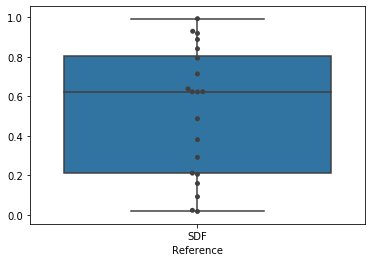

In [999]:
show_boxplot()

In [998]:
def show_boxplot():
    array = np.random.uniform(size=20)
    ax = sns.boxplot(data = array)
    ax = sns.swarmplot(data=array, color=".25")
    plt.xticks([0],['SDF'])
    plt.xlabel("Reference")
#     plt.show(ax)

In [ ]:
f = {}
f['1'] = {}
f['1'].update({'cc_objs':[]})
f['1'].update({'cc_atts':[]})
f['1'].update({'cc_elements':[]})
print(f)
print(f['1']['cc_objs'])
f.update({'2':{}})
print(f)


In [198]:
# def update_queue_s(cocluster_sequence_str, tested_sequence_str, s_poi_freq_queue_list, poi_node_queue):
def update_queue_s(cocluster_sequence_str, s_poi_freq_queue_list, poi_node_queue):
    '''
    Method to update the nodes in queue s. It decrements the value of a given node in s.
    The input are:
        1. The current string sequence of a cocluster;
        2. The tested string sequence to improve a cocluster;
        3. The queue s;
        4. A single node of queue s.
    '''
    # update list s when the first sequence is identified
#     if cocluster_sequence_str == '':
    tmp_split = cocluster_sequence_str.split('-')
    if len(tmp_split) == 2:
#         tmp_split = tested_sequence_str.split('-')
        s_poi_freq_queue_list.append(poi_node_queue)
        for attribute in tmp_split:
            for node_s in s_poi_freq_queue_list:
                if attribute == node_s[0]:
                    node_s[1] -= 1
                    if node_s[1] <= 0: # all occurences were used, then remove the element from the queue
                        print('Element with 0 removed.')
                        s_poi_freq_queue_list.remove(node_s)
                    break
    else: # update a single node in case a sequence is already discovered
        poi_node_queue[1] -= 1
        if poi_node_queue[1] <= 0: # all occurences were used, then remove the element from the queue
            s_poi_freq_queue_list.remove(node_s)
        else:
            s_poi_freq_queue_list.append(poi_node_queue)

In [199]:
def update_uppercase_S(cc_atts, cc_objs, S_dict):
    '''
    Method to update the dictonary S. It decrements the frequency of the given attributes in S.
    S is updated regarding the frequency of an attribute times the number of objects that it appears in a
    co-cluster.
    E.g., Given a co-clsuter with sequence Home-Work-Home with 5 trajectories. Then, in S, Home is 
    decremented with value 10 (2*5) and Work with value 5 (1*5).
    
    The input are:
        1. Co-cluster attributes;
        2. Co-cluster objects;
        3. The dictionary S of attributes and its frequency.
    '''
    tmp_dict = {}
    for attribute in cc_atts: # groups repeation
#         S_poi_freq_dict[attribute] -= 1
        try:
            tmp_dict[attribute] += 1
        except:
            tmp_dict.update({attribute:1})
    for attribute, value in tmp_dict.items():
        S_dict[attribute] -= (tmp_dict[attribute]*len(cc_objs))
        if S_dict[attribute] <= 0:
            S_dict.pop(attribute)

In [ ]:
a1 = ['a','b','c','d']
a2 = [1,2,3,4]
[str(i)+str(j) for i in a1 for j in a2]

In [ ]:
a = np.array([1,1,1,0,0,0,0])
b = np.array([1,1,3,0,0,0,0])
c = np.outer(a,b)
print(c)
d = (c*0)+1
print(d)
print(c+d)
e = d*4
print(e)
f = d-e
print(f)
print(sum(sum(f)))

In [ ]:
def myFunc(e):
    return e[:][1]

er = [['f',2],['h',5],['t',1]]
print(er)
er.sort()
print(er)
er.sort(reverse=True, key=myFunc)
print(er)
er[0][1] -= 1
print(er)

In [ ]:
t= [1,2,3,4,5,6,7,8]
print(t)
push_to_end = 3
complete_cicle = False
reload = True
print(t.pop(2))
print(t)
t= [1,2,3,4,5,6,7,8]
print(t)
# while(reload and complete_cicle != True):
#     for i in range(len(t)):
#         if t[i] == push_to_end:
#             tmp = t.pop(i)
#             t.append(tmp)
#             complete_cicle == True
#         else:
#             print(t[i])
#         if push_to_end == t[i] and complete_cicle == True:
#             reload = False
#             break
            


# Support functions for the algorithms

In [200]:
def get_data(input_data):
    '''
    This method will assign the variables used by the algorithm.
    
    INPUT
        input_data: A panda dataframe of the input data file.
    
    OUTPUT
        D: A binary matrix from the input data.
        N: A noise binary matrix with the same size of D.
        data_dict: A dictionary to store D as a vertical representation.
        data_res_dict: A copy of data_dict used to sort the attributes of D and find unconvered elements.
        
    '''
    
    data_pd = input_data #txt file with sequence of check-ins (POI)
    frequence_per_poi_dict = {} # store the frequence of a POI as "POI": num_of_occurrences
    poi_at_trajs_dict_set = {}  # store a set with each index line (tid trajectory) that contains a given POI.
                            # "POI": set(0,1,4,...); It is the S variable
#     global data_res_dict
    uncover_poi_dict = {} # It is the s* variable
#     global D # input data as a binary matrix
#     global N # noise matrix with the same size of D
    num_of_objects = 0
    num_of_attributes = 0
    map_id_to_attribute = {} # map the 
    map_attribute_to_id = {} # map the
    trajectory_dict = {} # it stores the trajectories with its check-ins. "TID": [POI1,POI2,...]
#     max_val_att = 0 
    att_id = 0 # assign an ID to each attribute
    
    # read each line
    for index, row in data_pd.iterrows():
        num_of_objects+=1
        object_data = row[0].split(" ")
#         trajectory_dict[str(index)] = {}
#         trajectory_dict[str(index)] = object_data
        trajectory_dict[str(index)] = []
        
#         for attribute in object_data: # we look at each item of the given transaction
        for att_j in range(len(object_data)): # we look at each item of the given transaction
            attribute = object_data[att_j]
            
            if attribute != "":
#                 if int(attribute) > max_val_att:
#                     max_val_att = int(attribute)
#                 if attribute not in map_unique_attributes_dataset:
#                 if attribute not in map_attribute_to_id.keys():
    
                if attribute not in map_attribute_to_id: # mapping
#                     unique_attributes_dataset.append(attribute)
                    map_attribute_to_id[attribute] = str(att_id)
                    map_id_to_attribute[str(att_id)] = attribute
                    att_id += 1
                
                # substitute the check-in by its ID
                trajectory_dict[str(index)].append(map_attribute_to_id[attribute])
                
                # store the indeces containing a given POI
                if map_attribute_to_id[attribute] in poi_at_trajs_dict_set:
#                     data_dict[map_attribute_to_id[attribute]].append(index)
                    poi_at_trajs_dict_set[map_attribute_to_id[attribute]].add(str(index))
                else:
#                     data_dict[map_attribute_to_id[attribute]] = [index]
                    poi_at_trajs_dict_set[map_attribute_to_id[attribute]] = set([str(index)])
                
                # store the frequence for each POI
                if map_attribute_to_id[attribute] in frequence_per_poi_dict:
                    current_value = frequence_per_poi_dict[map_attribute_to_id[attribute]]
                    frequence_per_poi_dict[map_attribute_to_id[attribute]] = current_value + 1
                else:
                    frequence_per_poi_dict[map_attribute_to_id[attribute]] = 1
            
                    
    uncover_poi_dict = poi_at_trajs_dict_set.copy()
#     num_of_attributes = len(data_dict)
#     num_of_attributes = max_val_att+1
#     num_of_attributes = len(map_attribute_to_id)
    print("######################################")
    print("Number of trajectories: "+str(index+1))
    print("Number of unique check-ins: "+str(len(map_attribute_to_id)))
    print("########################################")
    if VERBOSE:
        print("Map_attribute_to_id:"+str(map_attribute_to_id))
        print("")
        print("Map_id_to_attribute:"+str(map_id_to_attribute))
        print("")
        print("Frequence_per_poi:"+str(frequence_per_poi_dict))
        print("")
        print("Trajectories: "+str(trajectory_dict))
        print("")
        print("POI occurring at trajectories: "+str(poi_at_trajs_dict_set))
        print("Get data is DONE!")
        
    
#     D = np.zeros((num_of_objects,num_of_attributes),dtype=int)
#     for key, values in poi_at_trajs_dict.items():
#         print("key:"+str(key)+" Values:"+str(values))
#         for line in values:
# #             D[line][int(key)] = 1
# #             D[line][map_unique_attributes_dataset[key]] = 1
# #             print(line,key)
# #             print(type(line),type(key))
#             D[line][int(key)] = 1
#     N = np.zeros((num_of_objects,num_of_attributes),dtype=int)
    
#     return D, N, poi_at_trajs_dict, data_res_dict, map_id_to_attribute
    return map_id_to_attribute, frequence_per_poi_dict, poi_at_trajs_dict_set, trajectory_dict

In [943]:
df = pd.read_csv('data/real_application/foursquare_NY/fs_ny_top_users_10.csv', sep=";")
df_tmp = create_df_map_traj_user(df)
print(df_tmp[df_tmp['Tid'].isin([1,3,6])])
e = df_tmp[df_tmp['Tid'].isin([1,3,6])]['User'].value_counts()
print(e.to_dict())
print(df_tmp[df_tmp['Tid']==1]['User'].values[0])

   Tid  Traj_length  User
1    1           81   185
3    3           77   185
6    6           71   185
{185: 3}
185


In [201]:
# def create_df_map_traj_user(df):
def create_df_map_traj_user(df=pd.DataFrame):
    '''
    Method to support the calculation of the quality result.
    It returns a dataframe with the users and their trajectories with its respective length.
    '''
    try:
        #     df = pd.read_csv('data/real_application/foursquare_NY/fs_ny_top_users_10.csv', sep=";")
        df_map_traj_user = pd.DataFrame(columns=['Tid','Traj_length','User'])
        tids = []
        user = ''
        traj_length = 0

        sequence = []
        past_tid = None
        curr_tid = None
        num_of_seqs = 0
        map_element_id = 0
        unique_elements = {}
        map_id_to_element = {}

        for i in range(len(df)):
            curr_tid = df.loc[i,"new_tid"]
            if curr_tid not in tids:
                tids.append(int(curr_tid))
                user = int(df.loc[i,"label"])
                traj_length = len(df[df['new_tid'] == curr_tid])
                # append rows to an empty DataFrame
                df_map_traj_user = df_map_traj_user.append({'Tid' : curr_tid, 'Traj_length' : traj_length, 'User' : user},ignore_index = True)
        df_map_traj_user['Tid'] = df_map_traj_user['Tid'].astype(int, errors='ignore')
        df_map_traj_user['Traj_length'] = df_map_traj_user['Traj_length'].astype(int, errors='ignore')
        df_map_traj_user['User'] = df_map_traj_user['User'].astype(int, errors='ignore')

    #     print(df_map_traj_user.shape)
    #     print(df_map_traj_user.head())
    #     print('Todo DataFrame (traj_length):',' mean=',df_map_traj_user['Traj_length'].mean(),
    #           ' std=',df_map_traj_user['Traj_length'].std())
    #     u_185 = df_map_traj_user[df_map_traj_user['User']==185]
    #     print(u_185)
    #     print('User 185:',' mean=',u_185['Traj_length'].mean(),' std=',u_185['Traj_length'].std())
    #     df_map_traj_user.groupby(['label']).nunique()['new_tid'].mean()
        r = (df_map_traj_user.groupby(['User'])['Traj_length']
             .agg([np.count_nonzero,np.mean,np.std])
             .rename(columns={'count_nonzero':'Count_trajs',
                              'mean':'AVG_traj_length',
                              'std':'STD_traj_length'}))
    #     print('Número médio de trajs por usuário = {:.2f} com DP = {:.2f}'.format(r['Count_trajs'].mean(),
    #                                                                        r['Count_trajs'].std()))
    #     print('Tamanho médio das trajs por usuário = {:.2f} com DP médio = {:.2f}'.format(r['AVG_traj_length'].mean(),
    #                                                                        r['STD_traj_length'].mean()))
        return df_map_traj_user
    except:
        raise('Please, check the input data format.')
        return None
    

In [ ]:
from collections import deque
my_fila = deque([{'hotel':4},{'casa':7},{'trabalho':9},{'padaria':2}])
my_fila2 = deque()
my_fila2.append({'hotel':4})
my_fila2.append({'padaria':2})
print('Fila 1: ',type(my_fila))
print('Fila 1: ',my_fila)
print('Fila 2: ',my_fila2)
print(my_fila)
my_fila.append({'festa':1})
print(my_fila)
my_fila.appendleft({'aeroporto':1})
print(my_fila)
print(my_fila[1])
my_fila.insert(1,{'padaria':3})
print(my_fila)
print(len(my_fila))
print(my_fila.pop())
print(type(my_fila[2]))
r = my_fila[4]
print(r)
print(list(r.keys())[0])
print(my_fila.index(my_fila[4],2,len(my_fila)))
print('Fila 1: ',my_fila)
print('Fila 2: ',my_fila2)
my_fila.pop()#delete from the right end
my_fila.popleft()#delete from the left end
print('Fila 1: ',my_fila)
f = my_fila.popleft()
print('Fila 1: ',my_fila)
print('Element poped: ',f)
my_fila.append(f)
print(my_fila)
# my_fila.popleft()
# print(my_fila)
# my_fila.popleft()
# print(my_fila)
# my_fila.popleft()
# print(my_fila)
# my_fila.popleft()
# print(my_fila)
# print(my_fila)
# while my_fila:
#     fx = my_fila.popleft()
#     print(fx)
#     print(my_fila)
# for p in my_fila:
#     print(p)
print(num_elements_to_test('log2',len(my_fila)))
print(num_elements_to_test('log10',len(my_fila)))
print(num_elements_to_test('length',len(my_fila)))
print(my_fila)
my_fila.remove({'casa':7})
print(my_fila)

In [202]:
def num_elements_to_test(option,number):
    
    if option == 'log2':
        return int(round(np.log2(number)))
    elif option == 'log10':
        return int(round(np.log10(number)))
    elif option == 'length':# Attention! The number for length must to be at most length of structure. e.g. array, dic.
        return int(round(number))
    else:
        return print('Choose a valid option!')

### Too noisy (line,col)?

In [ ]:
def not_too_noisy(count_presence, C, e_obj, e_att, att_data_dict, E, dimension):
    num_of_atts = len(C[0])
    num_of_objs = len(C[1])
    if dimension == "obj":
        # obj must be present in at least (1-e_obj).||C_a||
        return count_presence >= ((1-e_obj) * num_of_atts) # return true if the obj is not too noisy
    else:
        # col must be present in at least (1-e_tt).||C_o||
        return count_presence >= ((1-e_att) * num_of_objs) # return true if the att is not too noisy

### cost function

In [203]:
def cost_function(numOfObj, numOfAtt, cov=0, noise=0):
    if VERBOSE:
        print('Num. objs: {0:2d}, Num. att: {1:2d}, Num. covered: {2:2d}, Num. noise: {3:2d}'.format(numOfObj,numOfAtt,cov,noise))
#     return ((numOfObj+numOfAtt) - (numOfObj*numOfAtt)) + cov + (2*noise)
    return ((numOfObj+numOfAtt) - (numOfObj*numOfAtt)) + cov + noise

### Sort attributes in dataset

In [ ]:
test_dict_freq = {'10':10,'45':45,'65':9,'87':2,'0':100}
sorted_attributes = sort_attributes(test_dict_freq)

In [204]:
def sort_attributes(data_res):
    
    try:
        ##usar este for caso o value seja uma lista
        freq_res_dict = {}
        for key,value in data_res.items():
            freq_res_dict[key] = len(value)

        # Create a list of tuples sorted by index 1 i.e. value field     
        listofTuples = sorted(freq_res_dict.items() , reverse=True, key=lambda x: x[1])# usar se value for lista
        # Iterate over the sorted sequence
        # for elem in listofTuples :
        #     print(elem[0] , " ::" , elem[1] )
    #     print(listofTuples)
        sorted_attributes = [elem[0] for elem in listofTuples]
    except:
        ## este é usado caso value seja um número
        sorted_attributes = {k: v for k, v in sorted(data_res.items(), reverse=True, key=lambda item: item[1])}
    
#     if VERBOSE:
#         print("Sorted att: ",sorted_attributes)
    return sorted_attributes

### Update residual dataset

In [ ]:
def update_residual_dataset(res_data, attributes_cocluster, objects_cocluster):
    for key, value in res_data.items():
        if key in attributes_cocluster:
            diff_objs = set(res_data[key]).difference(set(objects_cocluster))
            res_data[key] = list(diff_objs)
    return res_data

### Save results - check path

In [ ]:
def check_path(path_method):
    current_dir = os.getcwd()
    print(current_dir)
    res = os.path.exists(path_method)
    # clean the folder to save new data
    if res:
        #check if it is empty
        dir_empty = os.listdir(path_method)
        if len(dir_empty) != 0:
    #         shutil.rmtree("OutputAnalysis/kmeans/")
            rm = !rm -r --preserve-root './OutputAnalysis/ococlus/'*
            if not rm:
                print("OCoClus' folder was cleaned.")
    #             os.chdir(path_method)
            else:
                print("sad")
                print(rm)
        else:
    #         print("Empty!")
            pass
    #         os.chdir(path_method)
    else: # nothing exist so create it
        # trying to insert to flase directory 
        try: 
    #         os.chdir(fd) 
            os.mkdir(path_method)
            print("The path was created: "+path_method)

        # Caching the exception     
        except: 
            print("Something wrong with specified directory. Exception- ", sys.exc_info())

### Save clustering result into a txt file

In [ ]:
# def writeFileOutput(cols, rows, dataset, method='OCoClus', fileName='OCoClusResult'):
def writeFileOutput(co_clusters, dataset, method='OCoClus', fileName='OCoClusResult'):
    text = ""
#    for c in range(len(data.rows_)):
#        res = [i for i, val in enumerate(data.columns_[c]) if val]
#        for j in res:
#            text += str(j)+" "

#        res = [i for i, val in enumerate(data.rows_[c]) if val]
#        text += "["
#        for j in res:
#            text += str(j)+" "
#        text += "]\n"
    
    num_of_clusters = len(co_clusters)
    
#     for c in range(len(cols)):
    for c in range(num_of_clusters):
#         for i in cols[c]:
        for i in co_clusters[c][0]: # get the attributes in cluster c
            text += str(i)+" "
        
        text += "("+str(len(co_clusters[c][1]))+") [" # get the number of objects in clusters c
        for j in range(len(co_clusters[c][1])): # save in the file each obj
            if j+1 != len(co_clusters[c][1]):
                text += str(co_clusters[c][1][j])+" "
            else:
                text += str(co_clusters[c][1][j])
        text += "]\n"
    
    #print(text)
    if method == 'Dhillon':
        f = open('./datasets/outputs/'+fileName+'.txt', 'w+')#saving at dataset folder
        f.write(text)
        f.close()
        print("Output file saved in: "+"./datasets/outputs/"+fileName+".txt")
    elif method == 'Kluger':
        f = open('./datasets/outputs/'+fileName+'.txt', 'w+')#saving at dataset folder
        f.write(text)
        f.close()
        print("Output file saved in: "+"./datasets/outputs/"+fileName+".txt")
    elif method == 'OCoClus':
        f = open('./OutputAnalysis/ococlus/'+dataset+'/'+fileName+'.txt', 'w+')#saving at dataset folder
        f.write(text)
        f.close()
        print("Output file saved in: "+"./OutputAnalysis/ococlus/"+dataset+"/"+fileName+".txt")
    else:
        print("The output file was not generated. Method option not recognized.")

# Evaluation measure

### Reconstruction error

In [ ]:
def Rec_error(data,clusters):
    '''
    This evaluation measure is computed during the algorithm life time.
    '''
    reconstructed_ococlus = np.zeros(data.shape,dtype=int)
    for nc in range(len(clusters)):
        for i in clusters[nc][1]: # object cluster
            for j in clusters[nc][0]: # attribute cluster
                reconstructed_ococlus[int(i)][int(j)] = 1
    print("Reconstruction error: ",np.sum(np.bitwise_xor(data,reconstructed_ococlus)))

### Omega format

In [ ]:
def build_clustering_output_omega(co_clusters):
# def build_clustering_output_omega(rowClusters,columnClusters):
    '''
    Build the clustering output format to use in the omega index evaluation from Remy Cazabet version.
    It is optional and we just present this version as a complementary information. If you are interested,
    check it out on his team work group at https://github.com/isaranto/omega_index.
    '''
    
    num_of_clusters = len(co_clusters)    
    clustering = {}
    
    for nc in range(num_of_clusters):
        rowCluster = co_clusters[nc][1]
        columnCluster = co_clusters[nc][0]
        clustering["c"+str(nc)] = []
        
        for i in rowCluster:
            for j in columnCluster:
                clustering["c"+str(nc)].append(("01"+str(i)+"02"+str(j)))
        
    return clustering

### eXascale Infolab 
We used the xmeasure and OvpNMI project that pushished evaluation measures for overlapping task. We can check it on https://github.com/eXascaleInfolab/xmeasures or https://exascale.info/. Look their project on github to know how to use it.

In [ ]:
def xmeasures_format(dict_gt):
    '''
    This function build the xmeasure format to use it on their evaluation measure.
    '''
    newData = []
    for i in range(len(dict_gt)):
#         print(dict_gt['c'+str(i)])
        stringLine = dict_gt['c'+str(i)][0]
        for j in range(1,len(dict_gt['c'+str(i)])):
#             stringLine = stringLine+" "+dict_gt['c'+str(i)][j]
            stringLine += " "+dict_gt['c'+str(i)][j]
        newData.append(stringLine)
    
    return newData